The conjugate gradients algorithm uses steepest descents for its first step and then adjusts the search direction in an attempt to overcome the problems of steepest descents alone.

Let $x_0, x_1$ be two successive points where x1 has been obtained using steepest descents from $x_0$, and let $g_0, g_1$ be the corresponding gradients (the initial search direction is $s_0 = -g_0$). Take the second search direction as
\begin{equation}
    s_1 = -g_1 + \beta s_0 = -g_1 - \beta g_0 \quad \text{where} \quad \beta = \frac{g_1 \cdot g_1}{g_0 \cdot g_0}.
\end{equation}
If $f(x)$ is a quadratic function of $N$ variables, then the choice of directions may be continued up to the $N$-th search direction to give the $N$ conjugate directions
\begin{equation}
    s_k = -g_k + \beta s_{k-1} \quad \text{where} \quad \beta = \frac{g_k \cdot g_k}{g_{k-1} \cdot g_{k-1}}.
\end{equation}
In this case, if all the values of $\lambda^*$ had been chosen to minimise the $\phi(\lambda)$ exactly at each stage, then the algorithm would have converged. In practice, $f(x)$ may not be quadratic and the values $\lambda^*$ may not be chosen exactly, and in this case it is usual in practice to restart the method
after $N$ steps. When $N$ = 2, this implies that every other step is a steepest descent.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time

def bedpan_function(x, y):
    return x + y + (x**2 / 4) - y**2 + (y**2 - x / 2)**2

def bedpan_gradient(x, y):
    df_dx = 1 + x / 2 - (y**2 - x / 2)
    df_dy = 1 - 2 * y + 2 * (y**2 - x / 2) * (2 * y)
    return np.array([df_dx, df_dy])

def rosenbrock_like_function(x, y):
    return (1 - x)**2 + 80 * (y - x**2)**2

def rosenbrock_like_gradient(x, y):
    df_dx = -2 * (1 - x) - 320 * x * (y - x**2)
    df_dy = 160 * (y - x**2)
    return np.array([df_dx, df_dy])

In [20]:
def conjugate_gradient(func, grad_func, x0, num_iterations=10):
    '''
    Performs the Conjugate Gradients algorithm with restarts every N=2 steps.
    '''
    points_history = [x0]
    f_history = [func(x0[0], x0[1])]

    x_current = np.array(x0, dtype=float)
    g_prev = None
    s_prev = None

    print(f"Starting at x_0 = {x_current}, f(x_0) = {f_history[0]:.6f}")

    for i in range(num_iterations):
        g_current = grad_func(x_current[0], x_current[1])

        if i % 2 == 0:
            # Restart: Use steepest descent direction
            s_current = -g_current
            print(f"\n--- Iteration {i+1} (Steepest Descent Step) ---")
        else:
            # Conjugate gradient step
            # Calculate beta using the Fletcher-Reeves formula
            beta = np.dot(g_current, g_current) / np.dot(g_prev, g_prev)
            s_current = -g_current + beta * s_prev
            print(f"\n--- Iteration {i+1} (Conjugate Gradient Step) ---")

        # Perform line search
        phi = lambda lam: func(x_current[0] + lam * s_current[0], x_current[1] + lam * s_current[1])

        # Adjust lambda range based on function for better initial plot
        lambda_range = 0.1 if func == rosenbrock_like_function else 1.0
        lambda_vals = np.linspace(0, lambda_range, 400)
        phi_vals = [phi(l) for l in lambda_vals]

        plt.figure(figsize=(8, 6))
        plt.plot(lambda_vals, phi_vals)
        plt.title(f"Iteration {i+1}: Plot of $\\phi(\\lambda)$")
        plt.xlabel(f"$\\lambda$ (Step Size)")
        plt.ylabel(f"$\\phi(\\lambda) = f({x_current} + \\lambda s)$")
        plt.grid(True)
        plt.show()
        time.sleep(1)

        while True:
            try:
                lambda_star_str = input(
                    f"Examine the plot above. Enter the value of λ* for iteration {i+1}: \n"
                )
                lambda_star = float(lambda_star_str)
                break
            except ValueError:
                print("Invalid input. Please enter a number.")

        # Update point and store history ---
        x_next = x_current + lambda_star * s_current
        points_history.append(x_next)

        f_current_val = f_history[-1]
        f_next_val = func(x_next[0], x_next[1])
        f_history.append(f_next_val)

        decrease = f_current_val - f_next_val

        print(f"  Selected λ* = {lambda_star}")
        print(f"  New Point (x, y) = ({x_next[0]:.6f}, {x_next[1]:.6f})")
        print(f"  Current Value f(x_{i+1}) = {f_next_val:.6f}")
        print(f"  Decrease from last step = {decrease:.6f}")

        # Prepare for next iteration ---
        x_current = x_next
        g_prev = g_current
        s_prev = s_current

    return np.array(points_history), np.array(f_history)

def plot_optimization_path(func, points_history, f_values, title):
    x_coords = points_history[:, 0]
    y_coords = points_history[:, 1]
    x_buffer = (max(x_coords) - min(x_coords)) * 0.15 or 1.0
    y_buffer = (max(y_coords) - min(y_coords)) * 0.15 or 1.0
    x_range = np.linspace(min(x_coords) - x_buffer, max(x_coords) + x_buffer, 400)
    y_range = np.linspace(min(y_coords) - y_buffer, max(y_coords) + y_buffer, 400)
    X, Y = np.meshgrid(x_range, y_range)
    Z = func(X, Y)
    plt.figure(figsize=(8, 5))
    min_f_val = f_values[-1] if len(f_values) > 0 else 0
    fine_levels = np.linspace(min_f_val, min_f_val + 0.5, 20)
    coarse_levels = np.logspace(0, 3, 20)
    custom_levels = np.sort(np.concatenate([fine_levels, coarse_levels]))
    plt.contour(X, Y, Z, levels=custom_levels, cmap='viridis')
    plt.plot(x_coords, y_coords, 'r-o', label='Iteration Path')
    plt.plot(x_coords[0], y_coords[0], 'go', markersize=10, label='Start Point')
    plt.plot(x_coords[-1], y_coords[-1], 'bo', markersize=10, label='End Point')
    plt.title(title)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$y$')
    plt.legend()
    plt.grid(True)
    plt.colorbar(label=f'$f(x, y)$')
    plt.show()

Starting at x_0 = [-1.  -1.3], f(x_0) = 1.056100

--- Iteration 1 (Steepest Descent Step) ---


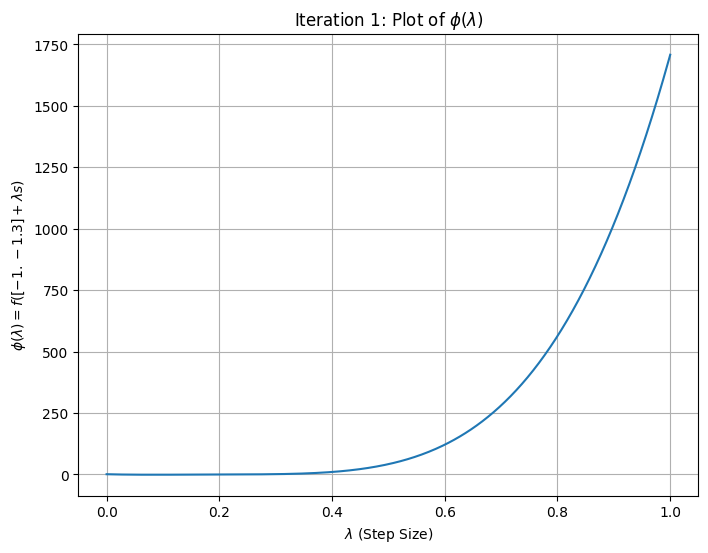

Examine the plot above. Enter the value of λ* for iteration 1: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (-0.831000, -0.521200)
  Current Value f(x_1) = -0.979035
  Decrease from last step = 2.035135

--- Iteration 2 (Conjugate Gradient Step) ---


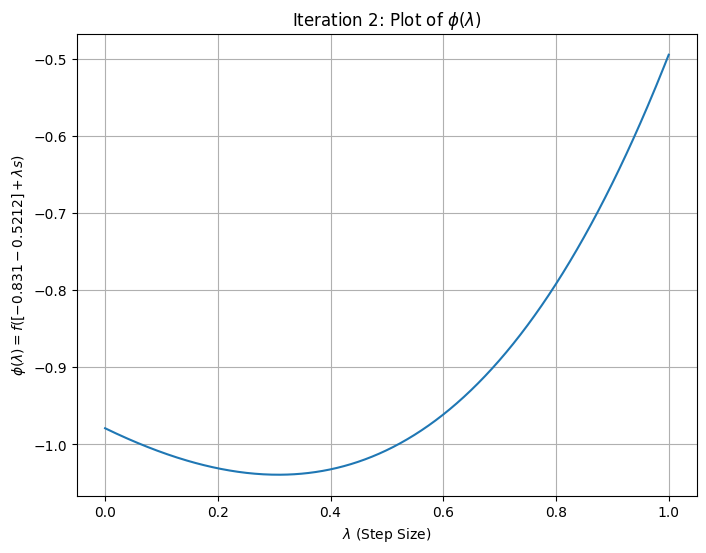

Examine the plot above. Enter the value of λ* for iteration 2: 
0.3
  Selected λ* = 0.3
  New Point (x, y) = (-0.797152, -0.690080)
  Current Value f(x_2) = -1.039328
  Decrease from last step = 0.060293

--- Iteration 3 (Steepest Descent Step) ---


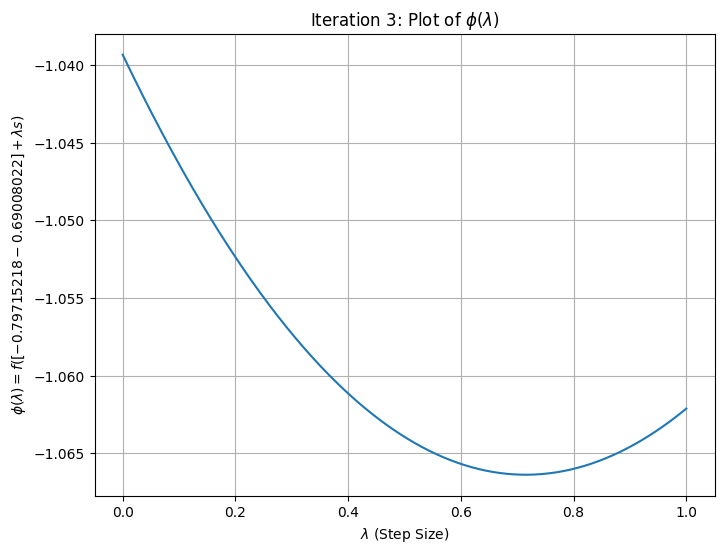

Examine the plot above. Enter the value of λ* for iteration 3: 
0.7
  Selected λ* = 0.7
  New Point (x, y) = (-0.605798, -0.665908)
  Current Value f(x_3) = -1.066379
  Decrease from last step = 0.027051

--- Iteration 4 (Conjugate Gradient Step) ---


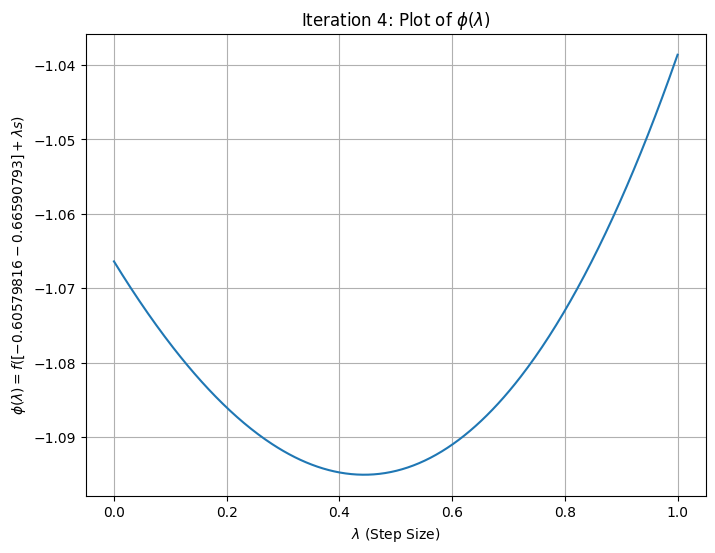

Examine the plot above. Enter the value of λ* for iteration 4: 
0.5
  Selected λ* = 0.5
  New Point (x, y) = (-0.363946, -0.810397)
  Current Value f(x_4) = -1.094527
  Decrease from last step = 0.028148

--- Iteration 5 (Steepest Descent Step) ---


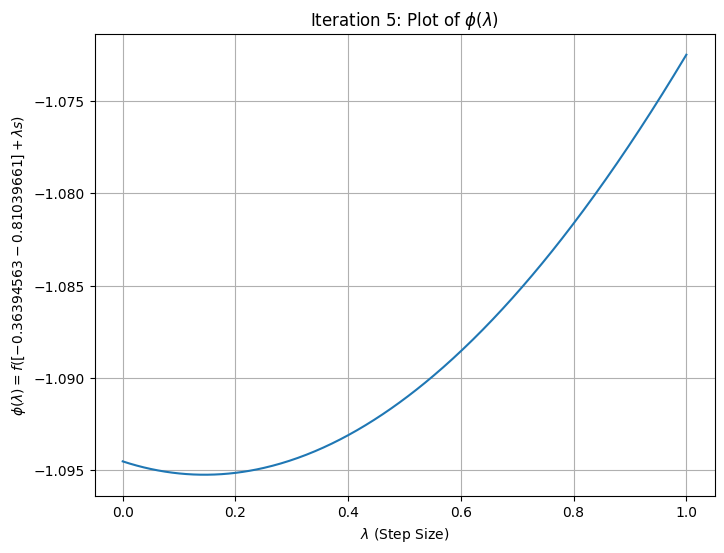

Examine the plot above. Enter the value of λ* for iteration 5: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (-0.361877, -0.800599)
  Current Value f(x_5) = -1.095181
  Decrease from last step = 0.000654

--- Iteration 6 (Conjugate Gradient Step) ---


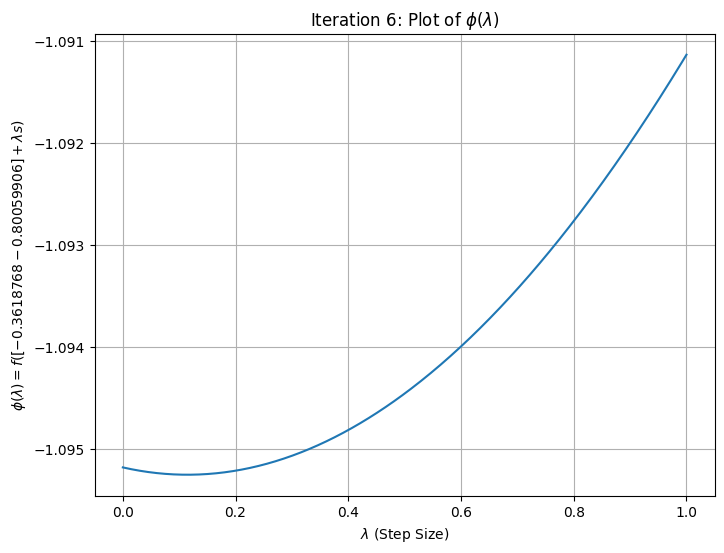

Examine the plot above. Enter the value of λ* for iteration 6: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (-0.361395, -0.796577)
  Current Value f(x_6) = -1.095251
  Decrease from last step = 0.000071

--- Iteration 7 (Steepest Descent Step) ---


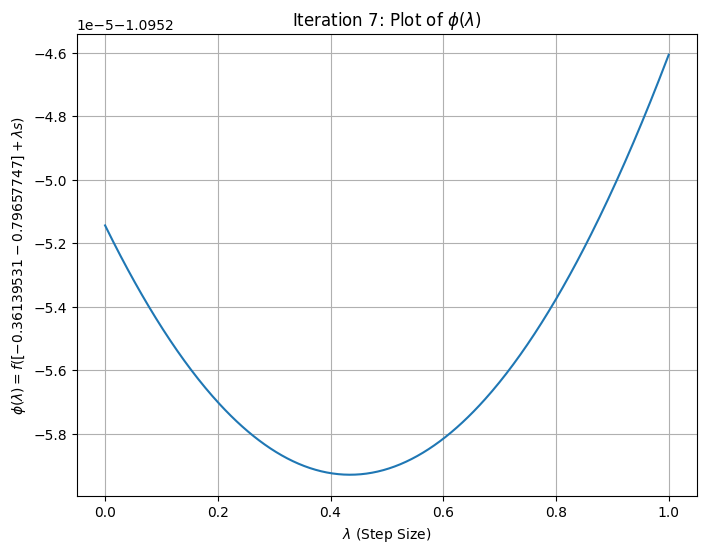

Examine the plot above. Enter the value of λ* for iteration 7: 
0.5
  Selected λ* = 0.5
  New Point (x, y) = (-0.363430, -0.794362)
  Current Value f(x_7) = -1.095259
  Decrease from last step = 0.000008

--- Iteration 8 (Conjugate Gradient Step) ---


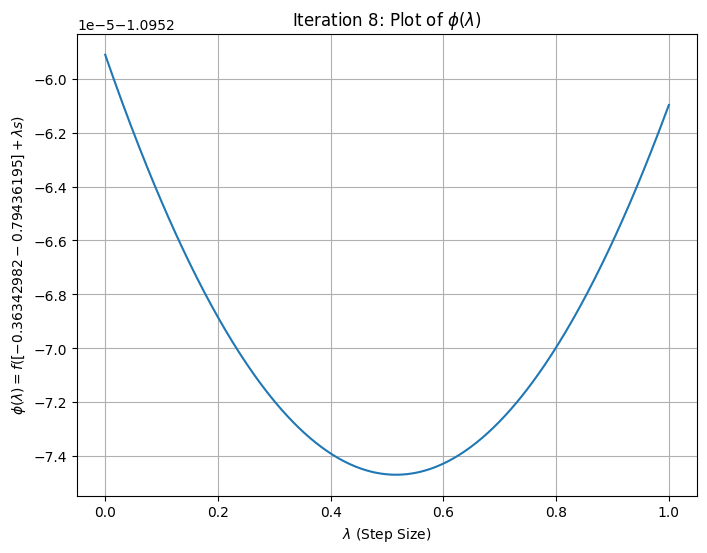

Examine the plot above. Enter the value of λ* for iteration 8: 
0.5
  Selected λ* = 0.5
  New Point (x, y) = (-0.370199, -0.793182)
  Current Value f(x_8) = -1.095275
  Decrease from last step = 0.000016

--- Iteration 9 (Steepest Descent Step) ---


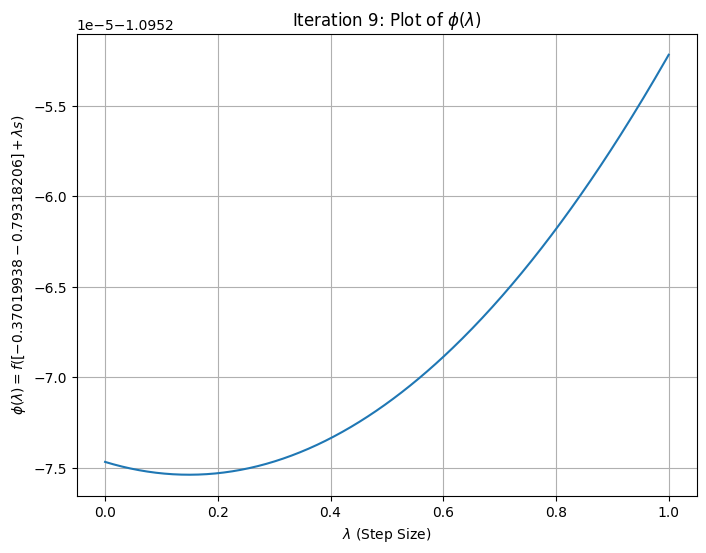

Examine the plot above. Enter the value of λ* for iteration 9: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (-0.370266, -0.793483)
  Current Value f(x_9) = -1.095275
  Decrease from last step = 0.000001

--- Iteration 10 (Conjugate Gradient Step) ---


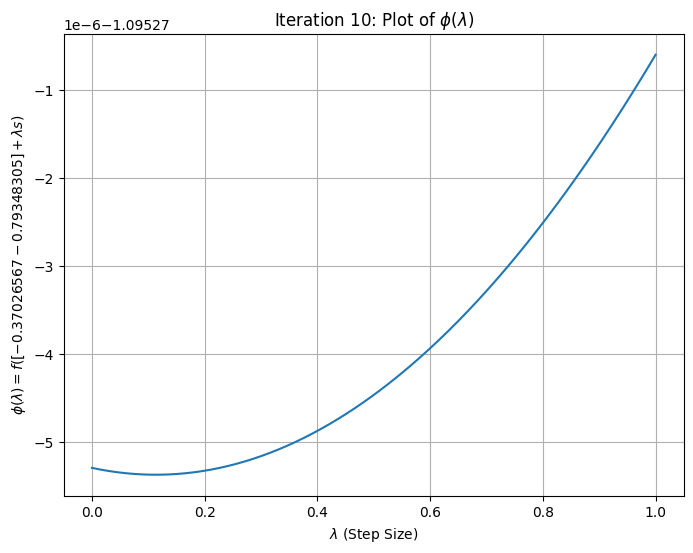

Examine the plot above. Enter the value of λ* for iteration 10: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (-0.370285, -0.793617)
  Current Value f(x_10) = -1.095275
  Decrease from last step = 0.000000

All iterations complete.


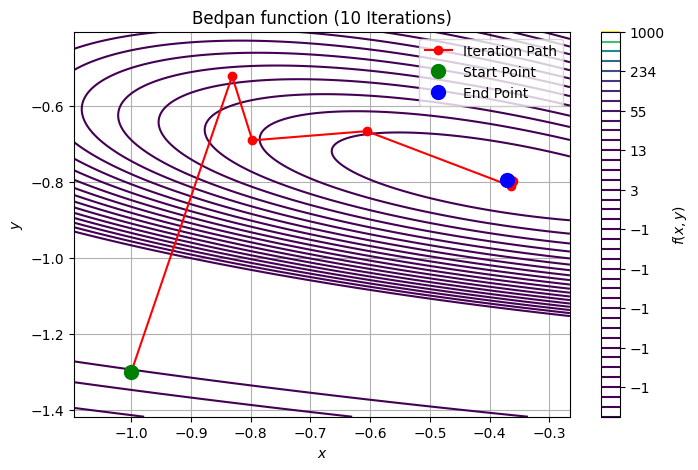

In [21]:
initial_point = np.array([-1.0, -1.3])
path_history, f_values = conjugate_gradient(
    bedpan_function,
    bedpan_gradient,
    initial_point,
    num_iterations = 10
)

print("\nAll iterations complete.")
plot_optimization_path(
    bedpan_function,
    path_history,
    f_values,
    title=f"Bedpan function ({10} Iterations)"
)

Starting at x_0 = [0.676 0.443], f(x_0) = 0.120602

--- Iteration 1 (Steepest Descent Step) ---


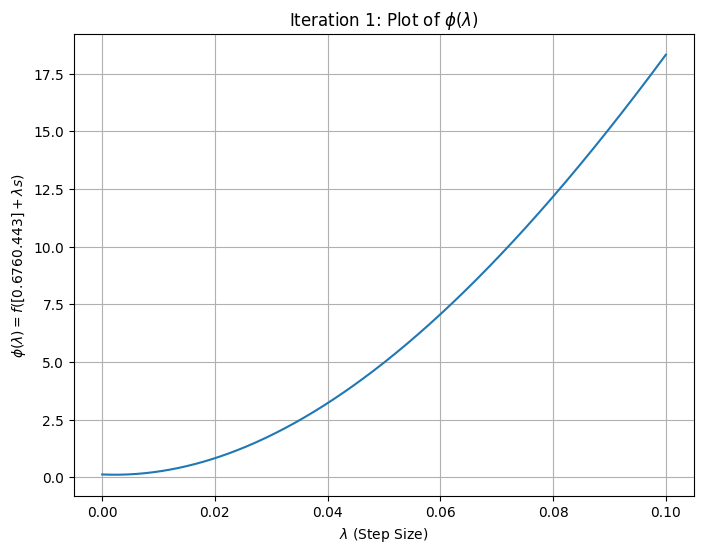

Examine the plot above. Enter the value of λ* for iteration 1: 
0.001
  Selected λ* = 0.001
  New Point (x, y) = (0.673625, 0.445236)
  Current Value f(x_1) = 0.112347
  Decrease from last step = 0.008255

--- Iteration 2 (Conjugate Gradient Step) ---


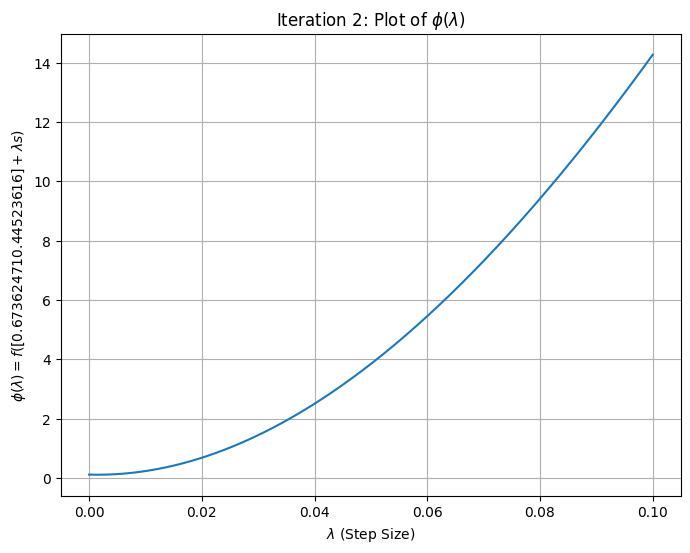

Examine the plot above. Enter the value of λ* for iteration 2: 
0.001
  Selected λ* = 0.001
  New Point (x, y) = (0.671707, 0.447289)
  Current Value f(x_2) = 0.108994
  Decrease from last step = 0.003354

--- Iteration 3 (Steepest Descent Step) ---


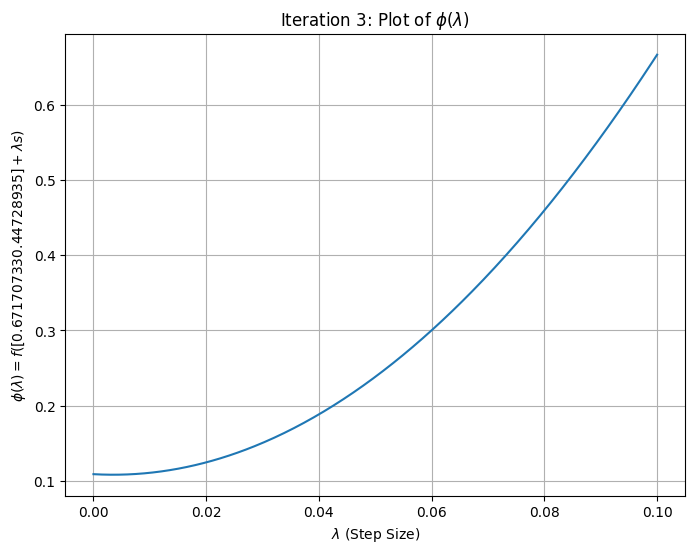

Examine the plot above. Enter the value of λ* for iteration 3: 
0.001
  Selected λ* = 0.001
  New Point (x, y) = (0.671525, 0.447914)
  Current Value f(x_3) = 0.108631
  Decrease from last step = 0.000362

--- Iteration 4 (Conjugate Gradient Step) ---


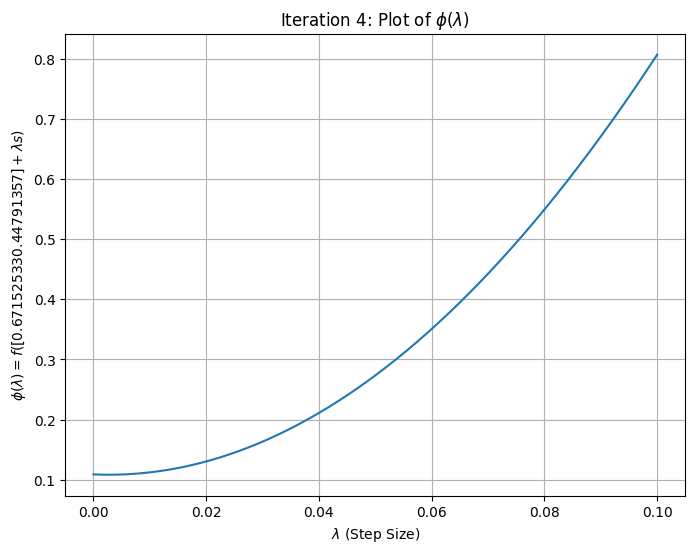

Examine the plot above. Enter the value of λ* for iteration 4: 
0.001
  Selected λ* = 0.001
  New Point (x, y) = (0.671429, 0.448746)
  Current Value f(x_4) = 0.108302
  Decrease from last step = 0.000330

--- Iteration 5 (Steepest Descent Step) ---


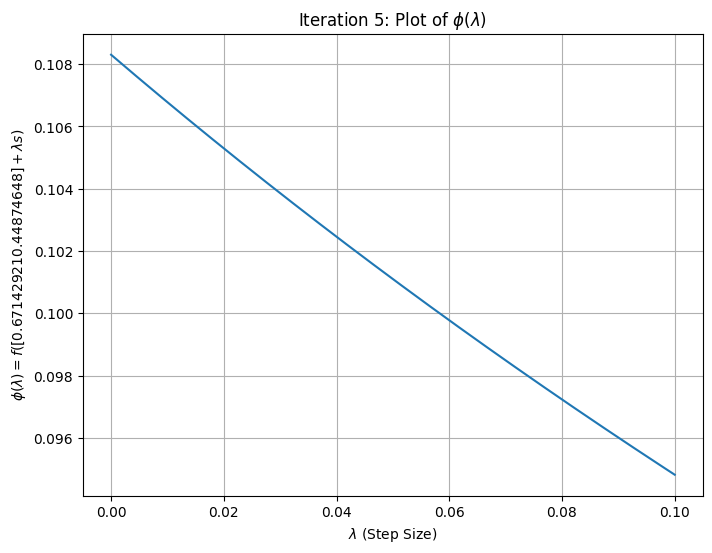

Examine the plot above. Enter the value of λ* for iteration 5: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (0.692653, 0.481878)
  Current Value f(x_5) = 0.094819
  Decrease from last step = 0.013483

--- Iteration 6 (Conjugate Gradient Step) ---


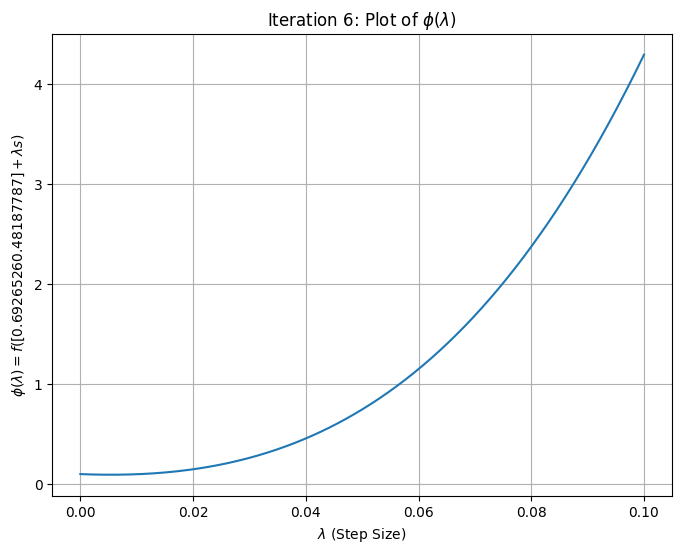

Examine the plot above. Enter the value of λ* for iteration 6: 
0.01
  Selected λ* = 0.01
  New Point (x, y) = (0.721102, 0.506016)
  Current Value f(x_6) = 0.093402
  Decrease from last step = 0.001416

--- Iteration 7 (Steepest Descent Step) ---


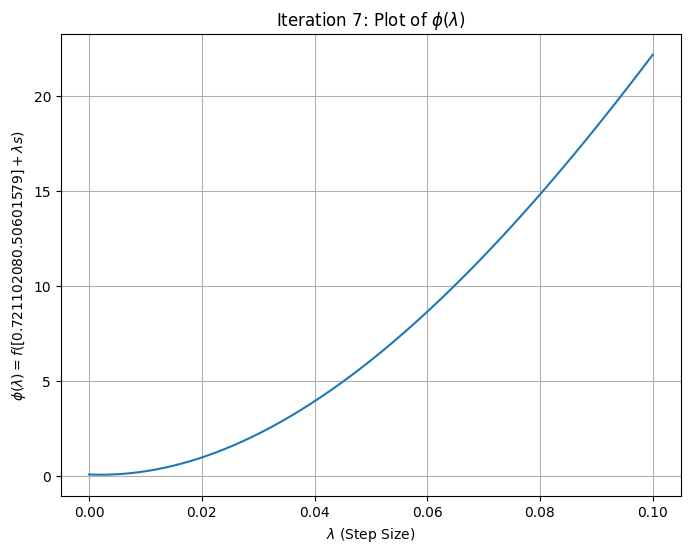

Examine the plot above. Enter the value of λ* for iteration 7: 
0.001
  Selected λ* = 0.001
  New Point (x, y) = (0.718436, 0.508251)
  Current Value f(x_7) = 0.084269
  Decrease from last step = 0.009133

--- Iteration 8 (Conjugate Gradient Step) ---


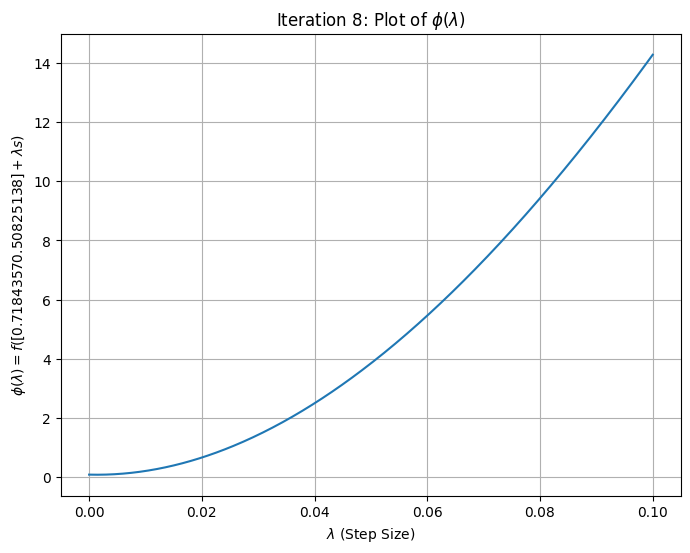

Examine the plot above. Enter the value of λ* for iteration 8: 
0.001
  Selected λ* = 0.001
  New Point (x, y) = (0.716486, 0.510100)
  Current Value f(x_8) = 0.081226
  Decrease from last step = 0.003043

--- Iteration 9 (Steepest Descent Step) ---


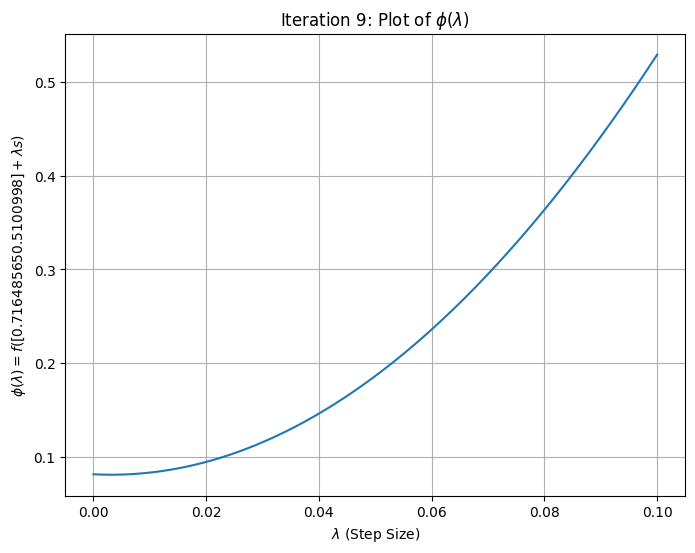

Examine the plot above. Enter the value of λ* for iteration 9: 
0.01
  Selected λ* = 0.01
  New Point (x, y) = (0.714700, 0.515303)
  Current Value f(x_9) = 0.083021
  Decrease from last step = -0.001794

--- Iteration 10 (Conjugate Gradient Step) ---


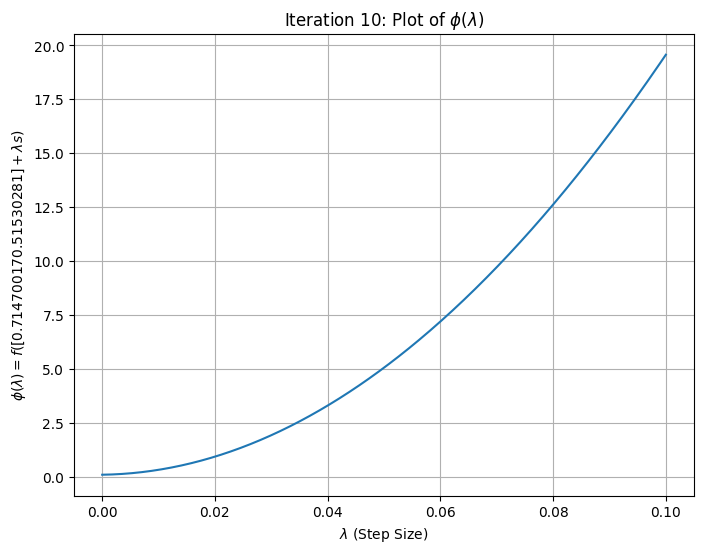

Examine the plot above. Enter the value of λ* for iteration 10: 
0.01
  Selected λ* = 0.01
  New Point (x, y) = (0.712516, 0.561119)
  Current Value f(x_10) = 0.311119
  Decrease from last step = -0.228098

All iterations complete.


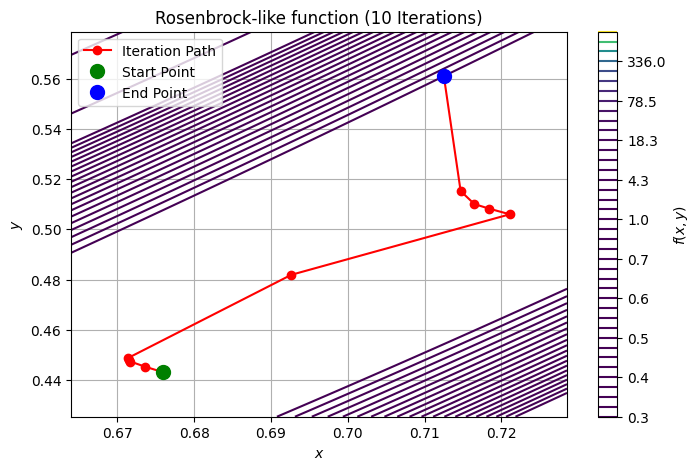

In [23]:
initial_point = np.array([0.676, 0.443])
path_history, f_values = conjugate_gradient(
    rosenbrock_like_function,
    rosenbrock_like_gradient,
    initial_point,
    num_iterations = 10
)

print("\nAll iterations complete.")
plot_optimization_path(
    rosenbrock_like_function,
    path_history,
    f_values,
    title=f"Rosenbrock-like function ({10} Iterations)"
)

On the ill-conditioned Rosenbrock-like function,steepest descents took many tiny, inefficient zigzag steps across the narrow valley. The conjugate gradients method, by contrast, takes much more purposeful strides along the valley floor. The CG steps successfully correct the poor direction chosen by the SD steps and mitigates the zigzagging behavior.

For a flat function like the Bedpan function, steepest descents converges slowly and remains far from the solution even after a moderate amount of iterations. The conjugate gradients method converges orders of magnitude faster, getting very close to the true minimum in just a handful of steps.
CG provides a solid acceleration, typically converging in about half the iterations of SD.

The small additional computational cost of the CG method (storing the previous gradient and search direction) is justified by its vastly superior performance, especially on the types of difficult optimization problems that can be found in practice.